# Homework CH7


請自行尋找及爬取一個網頁內容，下載網頁文章內容後，存成文字檔模式。並撰寫一程式讀取文字檔後，根據以下的議題做練習：

- 斷詞
- TF-IDF
- LDA
- 情感分析
- 文字雲

註：文字檔及程式檔都需上傳繳交


## 爬取網頁內容


In [1]:
import aiohttp


# 韓國戒嚴新聞
news_url = "https://www.cna.com.tw/news/aopl/202412073001.aspx"

async with aiohttp.ClientSession() as session:
    news_resp = await session.get(news_url)
    news_html = await news_resp.text()

print(news_html)

<!DOCTYPE html><html lang="zh-Hant-TW"><head><title>
	韓國總統尹錫悅為戒嚴道歉 國會7日下午表決彈劾 | 國際 | 中央社 CNA
</title><meta name="description" content="韓國國會將在今天下午表決對總統尹錫悅的彈劾案。尹錫悅上午在戒嚴風波後首度現身發表談話道歉，強調絕不會再有第2次。表決時若執政黨有8人以上跑票，彈劾案可望通過。" />
<meta charset="utf-8" />
<meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=5.0" />
<meta http-equiv="X-UA-Compatible" content="IE=edge" />
<meta http-equiv="X-UA-Compatible" content="IE=11" />
<link href="https://www.cna.com.tw/news/aopl/202412073001.aspx" rel="canonical" />
<meta property="article:modified_time" content="2024-12-07T13:14:00+08:00" />
<meta property="article:published_time" content="2024-12-07T10:38:00+08:00" />
<link href="https://imgcdn.cna.com.tw/www/webphotos/WebCover/800/20241207/1853x1390_778656743602.jpg" rel="image_src" type="image/jpeg" />
<meta property="author" content="中央通訊社" />
<link href="https://plus.google.com/102054703728087773572" rel="author" />
<link href="https://imgcdn.cna.com.tw/www/website/img/fav

Extract `.paragraph` from the website.


In [2]:
import re
from selectolax.parser import HTMLParser

tree = HTMLParser(news_html)
paragraph = tree.css(".paragraph > p")

# remove the last paragraph (copyright notice)
paragraph.pop()

article_paragraphs = [p.text() for p in paragraph]

# remove all the characters between the Chinese parentheses
parentheses_pattern = re.compile(r"（.*?）")
article_paragraphs = [parentheses_pattern.sub("", p) for p in article_paragraphs]

# remove the trailing date
date_pattern = re.compile(r"\d+$")
article_paragraphs = [date_pattern.sub("", p) for p in article_paragraphs]

print("\n".join(article_paragraphs))

韓國國會將在今天下午表決對總統尹錫悅的彈劾案。尹錫悅上午在戒嚴風波後首度現身發表談話道歉，強調絕不會再有第2次。表決時若執政黨有8人以上跑票，彈劾案可望通過。
尹錫悅3日夜間宣布戒嚴後，旋即因國會緊急通過撤銷而解嚴。這場6小時戒嚴風波震撼世界，引發民眾示威、在野發動彈劾。執政的國民力量黨5日還表示黨內議員將力阻在野陣營主導的彈劾案，然而6日黨魁韓東勳表示，尹錫悅應即刻停職。
韓國6個在野黨4日共同向國會提交總統彈劾議案，原訂當地時間7日晚間7時於國會表決，後來決定提前2小時改為下午5時表決。
國會議長辦公室表示，今天議程將先就設立特別檢察官調查總統夫人的立法進行表決，之後才是彈劾案投票。目前傳出執政的國民力量黨會先集體投票反對特檢立法，然後集體缺席彈劾表決。
彈劾案需國會總數300席裡2/3以上議員支持才能通過，門檻為200票，目前國會在野黨席次為192席，執政黨國民力量黨108席裡至少需8人以上倒戈，彈劾案才有機會通過。
若國會通過彈劾，尹錫悅將停職，由總理韓悳洙暫代總統職務，彈劾案則繼續交由憲法法院在180天內作終局裁定。
根據蓋洛普3到5日所做民調，戒嚴風波後尹錫悅的支持率再掉3個百分點至13%創新低；另據民調機構Realmeter在6日發布的數據，73.6%的受訪韓國民眾支持彈劾尹錫悅。
韓國國家情報院次長洪長元6日對外揭露，尹錫悅3日宣布戒嚴後曾親口下令逮捕多名朝野政要，除最大在野黨黨魁李在明、國會議長禹元植外，連執政黨黨魁韓東勳也名列逮捕名單。
韓東勳6日中午應尹錫悅之邀兩人私下會面。韓東勳會後表示，黨內仍希望尹錫悅停職，「沒聽到黨內有希望收回成命的聲音」。
尹錫悅7日上午於戒嚴風波後現身發表談話，為無預警宣布緊急戒嚴引發混亂道歉，除強調絕不會再有第2次外，也表示將由他所屬執政黨決定他的未來動向，自己不會規避政治和法律責任。
韓媒News1披露，執政的國民力量黨黨內親黨魁韓東勳的議員趙慶泰公開支持彈劾，安哲洙也表態如尹錫悅不主動下台，他將支持彈劾，但黨內多數仍維持先前立場反對彈劾。黨內議員尹相賢表示，就他觀察幾乎沒有人同意彈劾。


## 進行斷詞


使用中研院 CKIP Transformer 進行斷詞。


In [3]:
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger
import torch

device = torch.device("mps")
ws_driver = CkipWordSegmenter(model="bert-base", device=device)
pos_driver = CkipPosTagger(model="bert-base", device=device)

In [4]:
from TCSP import read_stopwords_list

ws = ws_driver(article_paragraphs, batch_size=512)
pos = pos_driver(ws, batch_size=512)

# accepted only these POS
# see https://ckip.iis.sinica.edu.tw/service/transformers/ for the full list
accepted_pos = [
    "Na",
    "Nb",
    "Nc",
    "Nv",
    "VA",
    "VAC",
    "VB",
    "VC",
    "VCL",
    "VD",
    "VF",
    "VE",
    "VG",
    "VH",
    "VHC",
    "VI",
    "VJ",
    "VK",
    "VL",
]

stopwords = read_stopwords_list()

# integrate ws with pos, with only the accepted pos and without the stopwords
ws_pos = [
    [
        (w, p)
        for w, p in zip(ws_sent, pos_sent)
        if p in accepted_pos and w not in stopwords and len(w) > 1
    ]
    for ws_sent, pos_sent in zip(ws, pos)
]

Inference: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


In [5]:
for sentence in ws_pos:
    for i, (word, pos) in enumerate(sentence):
        if i > 0 and i % 10 == 0:
            print()

        print(f"{word}({pos})", end=" ")

    print("\n")

韓國(Nc) 國會(Nc) 表決(VE) 總統(Na) 尹錫悅(Nb) 彈劾案(Na) 尹錫悅(Nb) 戒嚴(VH) 風波(Na) 現身(VA) 
發表(VC) 談話(Na) 道歉(VB) 強調(VE) 表決(VE) 執政黨(Na) 跑票(VA) 彈劾案(Na) 可望(VK) 

尹錫悅(Nb) 宣布(VE) 戒嚴(VH) 國會(Nc) 緊急(VH) 撤銷(VC) 解嚴(VA) 小時(Na) 戒嚴(VH) 風波(Na) 
震撼(VJ) 世界(Nc) 引發(VC) 民眾(Na) 示威(VA) 在野(VA) 發動(VC) 彈劾(VC) 執政(VA) 國民力量黨(Nb) 
表示(VE) 議員(Na) 力阻(VC) 在野(VA) 陣營(Na) 主導(VC) 彈劾案(Na) 黨魁(Na) 韓東勳(Nb) 表示(VE) 
尹錫悅(Nb) 停職(VB) 

韓國(Nc) 在野黨(Na) 國會(Nc) 提交(VD) 總統(Na) 彈劾(VC) 議案(Na) 原訂(VE) 時間(Na) 國會(Nc) 
表決(VE) 決定(VE) 提前(VB) 小時(Na) 改為(VG) 表決(VE) 

國會(Nc) 議長(Na) 辦公室(Nc) 表示(VE) 議程(Na) 設立(VC) 特別(VH) 檢察官(Na) 調查(VE) 總統(Na) 
夫人(Na) 立法(VA) 進行(VC) 表決(VE) 彈劾案(Na) 投票(VA) 傳出(VC) 執政(VA) 國民力量黨(Nb) 投票(VA) 
反對(VE) 特檢(Na) 立法(VA) 缺席(VH) 彈劾(VC) 表決(VE) 

彈劾案(Na) 國會(Nc) 總數(Na) 議員(Na) 支持(VC) 門檻(Na) 國會(Nc) 在野黨(Na) 席次(Na) 執政黨(Na) 
國民力量黨(Na) 倒戈(VA) 彈劾案(Na) 機會(Na) 

國會(Nc) 彈劾(VC) 尹錫悅(Nb) 停職(VB) 總理(Na) 韓悳洙(Nb) 暫代(VC) 總統(Na) 職務(Na) 彈劾案(Na) 
繼續(VF) 交由(VF) 憲法(Na) 法院(Nc) 終局(Na) 裁定(VE) 

蓋洛普(Nb) 民調(Na) 戒嚴(VH) 風波(Na) 尹錫悅(Nb) 支持率(Na) 百分點(Na) 民調(Na) 機構(Na) 發布(VE) 
數據(Na) 韓國(Nc) 

## TF-IDF


In [6]:
import polars as pl
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix

vectorizer = CountVectorizer()

words = [" ".join(w for w, _ in ws_sent) for ws_sent in ws_pos]

X = vectorizer.fit_transform(words)
assert isinstance(X, csr_matrix)

word = vectorizer.get_feature_names_out()

pl.from_numpy(X.toarray(), schema=word.tolist()).with_row_index()

index,下令,下台,世界,主動,主導,交由,倒戈,停職,傳出,公開,力阻,動向,原訂,反對,可望,同意,名列,名單,國家,國會,國民力量黨,在野,在野黨,執政,執政黨,夫人,安哲洙,宣布,小時,尹相賢,尹錫悅,希望,席次,引發,強調,彈劾,…,繼續,缺席,聲音,職務,聽到,蓋洛普,表態,表決,表示,裁定,規避,觀察,解嚴,設立,調查,談話,議員,議案,議程,議長,責任,趙慶泰,跑票,辦公室,逮捕,進行,道歉,門檻,陣營,震撼,韓國,韓媒,韓悳洙,韓東勳,預警,風波,黨魁
u32,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,2,0,0,0,1,0,…,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0
1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,2,0,1,0,0,0,1,1,0,2,0,0,1,0,1,…,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,1
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,…,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,…,0,1,0,0,0,0,0,2,1,0,0,0,0,1,1,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,…,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,0,0,1,0,0,1,0,0,2
8,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,…,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0


In [7]:
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer()
X_tfidf = transformer.fit_transform(X)
assert isinstance(X_tfidf, csr_matrix)

pl.from_numpy(X_tfidf.toarray(), schema=word.tolist()).with_row_index()

index,下令,下台,世界,主動,主導,交由,倒戈,停職,傳出,公開,力阻,動向,原訂,反對,可望,同意,名列,名單,國家,國會,國民力量黨,在野,在野黨,執政,執政黨,夫人,安哲洙,宣布,小時,尹相賢,尹錫悅,希望,席次,引發,強調,彈劾,…,繼續,缺席,聲音,職務,聽到,蓋洛普,表態,表決,表示,裁定,規避,觀察,解嚴,設立,調查,談話,議員,議案,議程,議長,責任,趙慶泰,跑票,辦公室,逮捕,進行,道歉,門檻,陣營,震撼,韓國,韓媒,韓悳洙,韓東勳,預警,風波,黨魁
u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.281026,0.0,0.0,0.0,0.0,0.141478,0.0,0.0,0.0,0.0,0.18879,0.0,0.0,0.0,0.0,0.0,0.259243,0.0,0.0,0.0,0.240211,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.422504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.240211,0.0,0.0,0.0,0.0,0.0,0.0,0.281026,0.0,0.0,0.0,0.240211,0.0,0.0,0.0,0.18879,0.0,0.0,0.0,0.0,0.18879,0.0
1,0.0,0.0,0.200722,0.0,0.200722,0.0,0.0,0.150886,0.0,0.0,0.200722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10105,0.134843,0.401444,0.0,0.150886,0.0,0.0,0.0,0.150886,0.17157,0.0,0.185164,0.0,0.0,0.17157,0.0,0.110651,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.243468,0.0,0.0,0.0,0.200722,0.0,0.0,0.0,0.150886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200722,0.200722,0.0,0.0,0.0,0.134843,0.0,0.134843,0.150886
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.282765,0.0,0.0,0.0,0.0,0.0,0.0,0.284706,0.0,0.0,0.212559,0.0,0.0,0.0,0.0,0.0,0.241697,0.0,0.0,0.0,0.0,0.0,0.0,0.155878,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.425118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.282765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.189958,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.198099,0.0,0.0,0.0,0.0,0.169328,0.0,0.0,0.0,0.0,0.0,0.099729,0.13308,0.0,0.0,0.148914,0.0,0.198099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.109205,…,0.0,0.198099,0.0,0.0,0.0,0.0,0.0,0.297828,0.120143,0.0,0.0,0.0,0.0,0.198099,0.198099,0.0,0.0,0.0,0.198099,0.169328,0.0,0.0,0.0,0.198099,0.0,0.198099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.314925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.317088,0.211563,0.0,0.236735,0.0,0.211563,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.314925,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.236735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.314925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.249039,0.0,0.0,0.0,0.0,0.148822,…,0.0,0.0,0.0,0.0,0.0,0.269965,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.181359,0.0,0.0,0.0,0.0,0.181359,0.0
7,0.211719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.211719,0.211719,0.211719,0.106586,0.0,0.0,0.159153,0.0,0.14223,0.0,0.0,0.159153,0.0,0.0,0.097654,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.18097,0.0,0.0,0.0,0.0,0.423438,0.0,0.0,0.0,0.0,0.0,0.14223,0.0,0.0,0.14223,0.0,0.0,0.318306
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.211864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.259994,0.563681,0.0,0.0,0.0,0.0,…,0.0,0.0,0.28184,0.0,0.28184,0.0,0.0,0.0,0.170931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.378674,0.0,0.0,0.0


## LDA


In [8]:
from numpy import ndarray
from sklearn.decomposition import LatentDirichletAllocation

assert isinstance(X_tfidf, csr_matrix)
X_tfidf_dense = X_tfidf.todense()

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_tfidf)

topic_dict: dict[str, list[ndarray]] = {}

for i, topic in enumerate(lda.components_):
    assert isinstance(topic, ndarray)

    topic_word = [word[j] for j in topic.argsort()[:-11:-1]]
    topic_dict[f"Topic {i}"] = topic_word

pl.DataFrame(topic_dict)

Topic 0,Topic 1,Topic 2,Topic 3,Topic 4
str,str,str,str,str
"""國民力量黨""","""國會""","""國民力量黨""","""立法""","""表決"""
"""風波""","""彈劾案""","""風波""","""投票""","""尹錫悅"""
"""總統""","""民調""","""總統""","""戒嚴""","""彈劾"""
"""執政黨""","""尹錫悅""","""執政黨""","""表決""","""韓東勳"""
"""宣布""","""支持""","""宣布""","""表示""","""希望"""
"""彈劾""","""逮捕""","""彈劾""","""政治""","""表示"""
"""國會""","""在野黨""","""國會""","""責任""","""國會"""
"""彈劾案""","""執政黨""","""彈劾案""","""預警""","""彈劾案"""
"""尹錫悅""","""韓國""","""尹錫悅""","""規避""","""議員"""


## 情感分析


In [9]:
import polars as pl
from paddlenlp import Taskflow

senta = Taskflow("sentiment_analysis", model="skep_ernie_1.0_large_ch", batch_size=256)

paragrpahs_sentiments = pl.DataFrame(senta(article_paragraphs))

/Volumes/Dev/nkust/nkust-homework/semester-5/big-data-business-decision/hw07impl/.venv/lib/python3.11/site-packages/paddle/utils/cpp_extension/extension_utils.py:686: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
/Volumes/Dev/nkust/nkust-homework/semester-5/big-data-business-decision/hw07impl/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
[2024-12-07 17:36:15,161] [    INFO] - tokenizer config file saved in /Users/pan93412/.paddlenlp/models/skep_ernie_1.0_large_ch/tokenizer_config.json
[2024-12-07 17:36:15,161] [ 

In [10]:
paragrpahs_sentiments

text,label,score
str,str,f64
"""韓國國會將在今天下午表決對總統尹錫悅的彈劾案。尹錫悅上午在戒…","""negative""",0.985281
"""尹錫悅3日夜間宣布戒嚴後，旋即因國會緊急通過撤銷而解嚴。這場…","""negative""",0.636329
"""韓國6個在野黨4日共同向國會提交總統彈劾議案，原訂當地時間7…","""negative""",0.929938
"""國會議長辦公室表示，今天議程將先就設立特別檢察官調查總統夫人…","""negative""",0.925554
"""彈劾案需國會總數300席裡2/3以上議員支持才能通過，門檻為…","""negative""",0.970933
…,…,…
"""根據蓋洛普3到5日所做民調，戒嚴風波後尹錫悅的支持率再掉3個…","""negative""",0.986606
"""韓國國家情報院次長洪長元6日對外揭露，尹錫悅3日宣布戒嚴後曾…","""negative""",0.980414
"""韓東勳6日中午應尹錫悅之邀兩人私下會面。韓東勳會後表示，黨內…","""negative""",0.944456


## 文字雲


[2024-12-07 17:36:40,486] [ WARNING] __init__.py:3534 - meta NOT subset; don't know how to subset; dropped


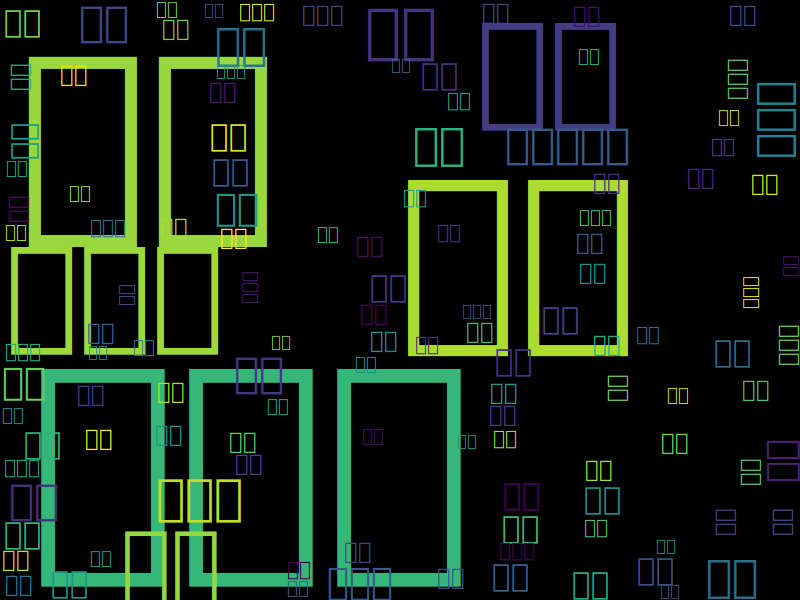

In [12]:
from collections import Counter
from wordcloud import WordCloud
from IPython.display import SVG

words = [w for ws_sent in ws_pos for w, _ in ws_sent]
counter = Counter(words)

wordcloud = WordCloud(
    font_path="LXGWWenKaiTC-Regular.ttf", width=800, height=600
).generate_from_frequencies(counter)
wordcloud_svg = wordcloud.to_svg(embed_font=True)

SVG(data=wordcloud_svg)